In [1]:
import sys                                   ###mcl1 全部のセルを掲載
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal  #追加

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):        ###EstimationAgent5
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0       #追加
        self.prev_omega = 0.0 #追加
        
    def decision(self, observation=None): #追加
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

<IPython.core.display.Javascript object>


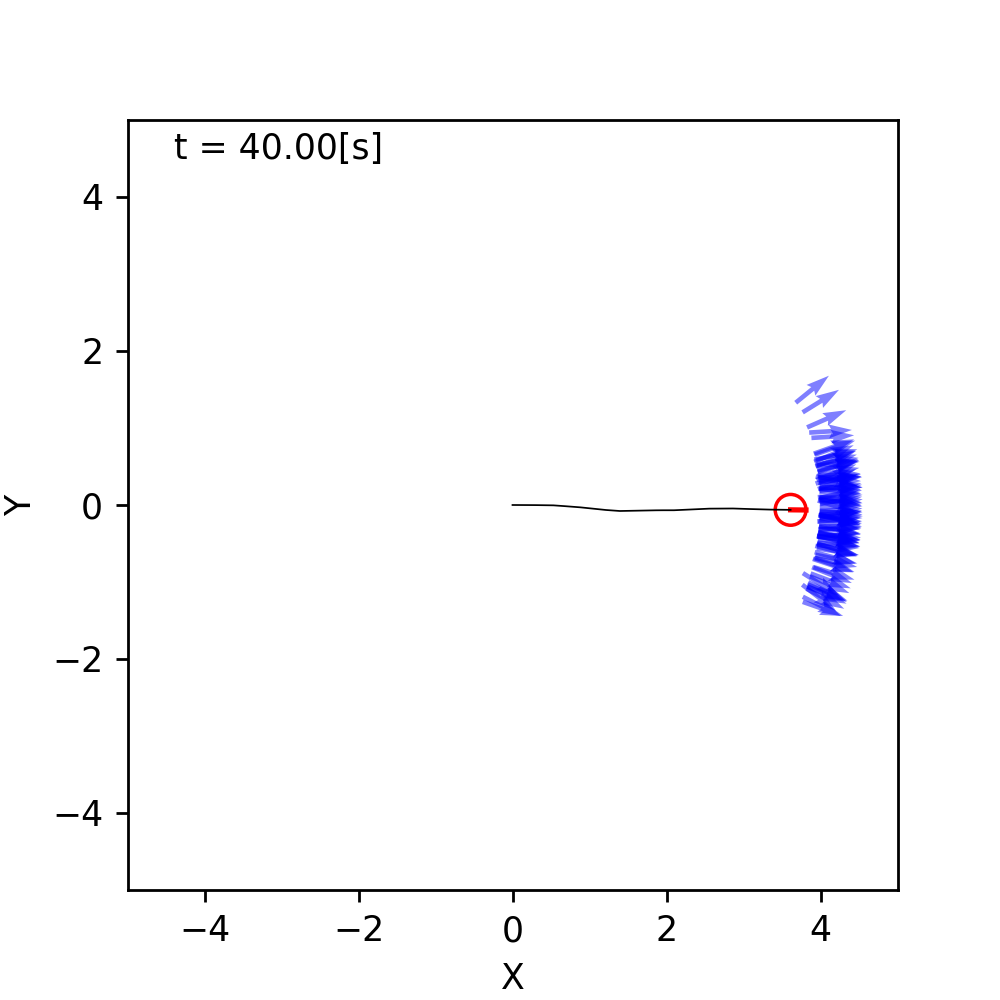

In [5]:
time_interval = 0.1 ###mcl_confirmation6
world = World(40, time_interval)

initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.001, "no":0.001, "on":0.13, "oo":0.001}) #onを0.13に
a = EstimationAgent(time_interval, 0.1, 0.0, estimator)
r = Robot(initial_pose, sensor=None, agent=a, color="red" )
world.append(r)

world.draw()